# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import matplotlib.patches as mpatches
import itertools
import twitter
import time
import requests
import datetime
import dateutil
import csv
import os
import json
import collections

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='v

## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_PATH = 'train.csv'
TESTING_SET_PATH = 'test.csv'
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=',', header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=',', header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head(7)

C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0
5,17938477,1.0
6,720288026681716737,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

## Сбор данных

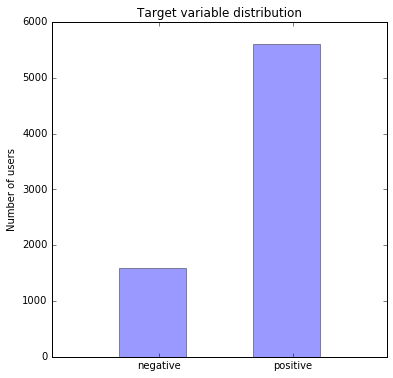

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train['cls'], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ['negative', 'positive'])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel('Number of users')
pl.title('Target variable distribution')
pl.show()

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = 'PUT_KEY_HERE'
CONSUMER_SECRET = 'PUT_SECRET_HERE'

ACCESS_TOKEN_KEY = 'PUT_TOKEN_KEY_HERE'
ACCESS_TOKEN_SECRET = 'PUT_TOKEN_SECRET_HERE'

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)


Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [5]:
##############################################
# Common
##############################################

def load_file(handler, fname):
    if os.path.exists(fname):
        with open(fname, 'r') as f:
            for line in f:
                try:
                    handler(line)
                except:
                    continue

def dump_json(obj, fname):
    with open(fname, 'a') as f:
        json.dump(obj, f)
        f.write('\n');
        
def timestamp():
    return time.strftime('%H:%M:%S')
        
class PersistentGetter(object):
    def __init__(self, name, trycnt):
        self.name = name
        self.trycnt = trycnt
    def __call__(self, original_func):
        decorself = self
        def wrappee(q):
            for tried in xrange(1, self.trycnt + 1):
                try:
                    return original_func(q)
                except Exception as ex:
                    print '\r[WRN {}]'.format(timestamp()),
                    print '{} failed {}/{}:'.format(decorself.name, tried, decorself.trycnt),
                    print 'q ={}, err = {}'.format(q, ex)
            print '\r[ERR {}] {} failed {} times'.format(timestamp(), decorself.name, decorself.trycnt)
            raise SystemExit
        return wrappee

class PersistentTwitterGetter(object):
    def __init__(self, name, trycnt, waitcnt):
        self.name = name
        self.trycnt = trycnt
        self.waitcnt = waitcnt
    def __call__(self, original_func):
        decorself = self
        def wrappee(q):
            waited = 0
            tried = 0
            delay = 60
            while True:
                try:
                    return original_func(q)
                except twitter.TwitterError as e:
                    if (e[0][0]['code'] == 88): # rate limit exceeded
                        tried = 0
                        waited += 1
                        if waited == 1:
                            print '\r[INF {}] Rate Limit Exceeded. Retrying every {} sec'.format(timestamp(), delay),
                        elif waited < decorself.waitcnt:
                            print '.',
                        else:
                            print '\r[ERR {}] Waited for too long. Stopping.'.format(timestamp())
                            raise SystemExit
                        time.sleep(60)
                    else:
                        print '\r[WRN {}] {} failed q = {}: {}'.format(timestamp(), decorself.name, q, e[0][0])
                        return None
                except Exception as ex:
                    tried += 1
                    print '\r[WRN {}]'.format(timestamp()),
                    print '{} failed {}/{}:'.format(decorself.name, tried, decorself.trycnt),
                    print 'q ={}, err = {}'.format(q, ex)
                    if tried >= decorself.trycnt:
                        print '\r[ERR {}] {} failed {} times'.format(timestamp(), decorself.name, decorself.trycnt)
                        raise SystemExit    
        return wrappee

In [6]:
##############################################
# local cache
##############################################

geoqueries = dict()
geoqueries_fname = 'tmp_geoqueries'
def load_geoquery(line):
    r = json.loads(line)
    geoqueries[r[0]] = r[1]
    
geoentries = dict()
geoentries_fname = 'tmp_geoentries'
def load_geoentry(line):
    r = json.loads(line)
    geoentries[r['geonameId']] = r
    
load_file(load_geoquery, geoqueries_fname)
load_file(load_geoentry, geoentries_fname)

def cache_geodata(q, entry):
    global geoqueries, geoentries
    if q in geoqueries:
        print '\r[ERR {}] Location query {} is already in cache'.format(timestamp(), q)
        raise SystemExit
    
    geoId = None if entry is None else entry["geonameId"]
    if geoId is not None and geoId not in geoentries:
        dump_json(entry, geoentries_fname)
        geoentries[geoId] = entry
    if q not in geoqueries:
        dump_json((q, geoId), geoqueries_fname)
        geoqueries[q] = geoId

##############################################
# Geonames API
##############################################

GEO_USER_NAME = 'PUT_USERNAME_HERE'

@PersistentGetter('Geonames GET request', 3)
def geonames_GET(q):
    url = 'http://api.geonames.org/search'
    payload = {'q': q, 'type': 'json', 'maxRows': 1, 'username': GEO_USER_NAME}
    return requests.get(url, params=payload).json()
    
def geonames_get_entry(q):
    r = geonames_GET(q)
    while True:
        if 'totalResultsCount' in r:
            return r['geonames'][0] if r['totalResultsCount'] >= 1 else None
        elif 'status' in r:
            print '[Err {}] Geonames request return status {}'.format(timestamp(), r['status'])
            #if r['status']['value'] == 19:
            #       
        else:
            print '[Err {}] Geonames request return unexpected json value: {}'.format(timestamp(), r)
        raise SystemExit
        
def get_geoentry(location):
    q = location.strip()
    if q in geoqueries:
        geoId = geoqueries[q]
        entry = None if geoId is None else geoentries[geoqueries[q]]
    else:
        entry = geonames_get_entry(q)
        cache_geodata(q, entry)
    return entry

##############################################
# get_coordinates_by_location
##############################################

def get_coordinates_by_location(location):
    entry = get_geoentry(location)
    if entry is None or 'countryName' not in entry:
        return (None, None, None)
    return (entry['lat'], entry['lng'], (entry['countryName'] if 'countryName' in entry else None))

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [7]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
user_records_fname = 'tmp_user_records'
def load_user_record(line):
    user_records.append(json.loads(line))
load_file(load_user_record, user_records_fname)

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])

@PersistentTwitterGetter('Twitter.GetUser', 3, 16)
def get_user(uid):
    return api.GetUser(user_id = uid)

@PersistentTwitterGetter('Twitter.UsersLookup', 3, 16)
def users_lookup(uids_list):
    return api.UsersLookup(user_id = uids_list)
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
    
    try:
        if user.location is not None and user.location.strip() != "":
            record["location"] = user.location
            record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    except:
        return None
    return record

def get_user_records(df):
    global bad_uids
    loaded_records = []
    uids = filter(lambda x: x not in processed_users, df['uid'])
    chunk_size = 100
    for i in xrange(0, len(uids), chunk_size):
        print '\rLoading[{}/{}, {}]'.format(i, len(uids), timestamp()),      
        users = users_lookup(uids[i: i + chunk_size])
        if users is None:
            print '0'
            continue
        print '({}/{})'.format(len(users),chunk_size),
        new_records = filter(lambda r: r is not None, map(twitter_user_to_dataframe_record, users))
        loaded_records.extend(new_records)
        with open(user_records_fname, 'a') as f:
            for r in new_records:
                json.dump(r, f)
                f.write('\n');
    return loaded_records


# Maximum number of user IDs returned by Twitter's user lookup

print "Loading twitter data [{}]".format(timestamp())
user_records.extend(get_user_records(df_users))

print "Creating data frame from loaded data [{}]".format(timestamp())
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set [{}]".format(timestamp())
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame [{}]".format(timestamp())

Loading twitter data [00:57:54]
[WRN 00:57:55] Twitter.UsersLookup failed q = [3091562110, 760201676187918336, 1622658864, 969130340, 3180615749, 737870316614090752, 3040779431, 2469084638, 67128081, 3820837817, 1443851580, 3303414341, 3091540181, 1261920379, 3091536717, 1619555502, 764437819003588608, 3300117046, 1622246287, 1931381994, 2885533222, 184041122, 3091581208, 3046632772, 2881505805, 3251721303, 3019643144, 3023439110, 62972578, 3019578000, 2885751389, 442584877, 2885786680, 1261917972, 3091612540, 4851461044, 1553483714, 2881708636, 2881676698, 2881586477, 769858756272283648, 2881544913, 764136346357272576, 745745537442381826, 3027935565, 3022688287, 3302519375, 2885475279, 3036353135, 3432242987, 3022622838, 1619845266, 1261903566, 763435751937831000, 748669315486884000, 739133063515365000, 735603874417938000, 749686272579428000, 709093222341980000, 760103091580666000, 728547380761502000, 704380756072608000, 702709923701002000, 762491273764668000, 713195014226969000, 7489

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

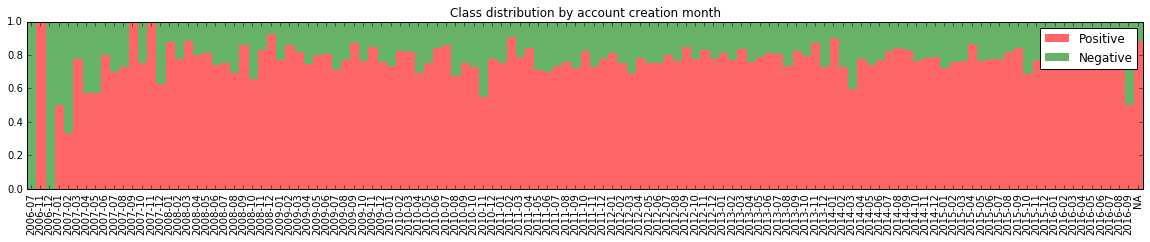

In [8]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """

    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    for date,group in grouped:
        count_pos[len(dts)] = sum(1 for u in filter(lambda x: x == 1.0, group['cls']))
        count_neg[len(dts)] = sum(1 for u in filter(lambda x: x == 0.0, group['cls']))
        dts.append(date)
    
    #posdict, negdict = defaultdict(int), defaultdict(int)
    return count_pos, count_neg, dts

grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)

pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()


Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


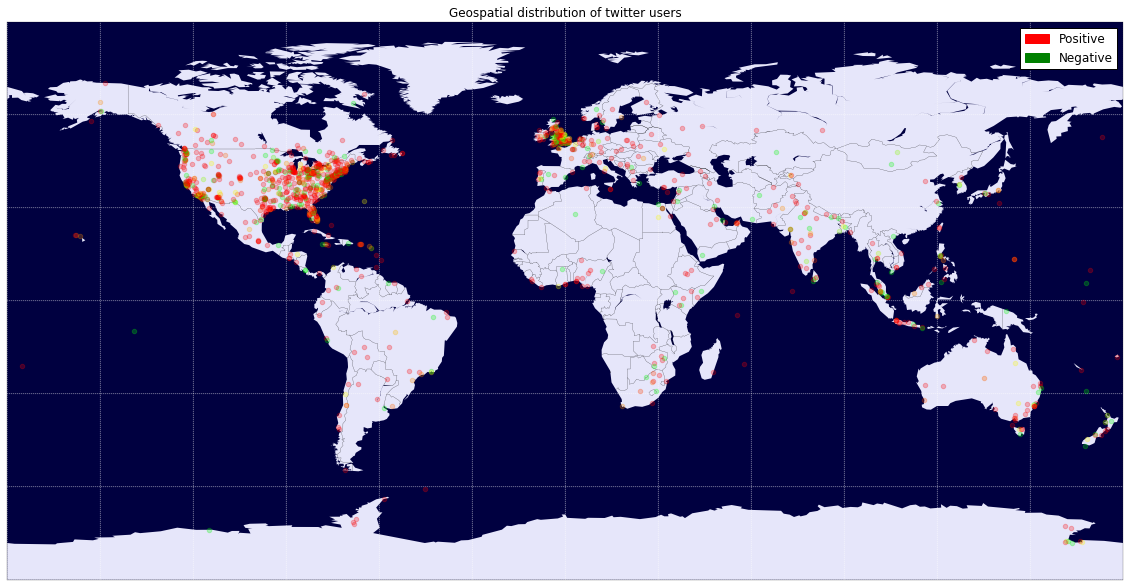

In [9]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)
  
def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """ 
    df_located = df_full[pd.notnull(df_full['lat'])]
    df_todraw = df_located[pd.notnull(df_located['cls'])]
    grouped = df_todraw.groupby(['lat', 'lon'])
    d = [(xy[0], xy[1], df[df['cls'] == 1].shape[0], df[df['cls'] == 0].shape[0]) for xy, df in grouped]
    M = max(max(d, key = lambda v: max(v[2], v[3]))[2:4])

    for lat,lon,v1,v0 in d:
        x,y = m(lon,lat)
        if v1 + v0 == 0:
            print lat,lon,v1,v0
            break
        r = 0.09 + v1 * 0.9 / max(v1, v0) if v1 > 0 else 0
        g = 0.09 + v0 * 0.9 / max(v1, v0) if v0 > 0 else 0
        alpha = 0.25 + max(v1, v0) * 0.75 / (2 * M)
        m.scatter(x, y, zorder=10, color=(r, g, 0.0), alpha=alpha)
    
    
plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
red_patch = mpatches.Patch(color='red', label='Positive')
green_patch = mpatches.Patch(color='green', label='Negative')
pl.legend(handles=[red_patch, green_patch])
pl.show()

В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Легенда
* Для каждого уникального местоположения, в котором есть классифицированные пользователи, отрисовывается единственный полупрозрачный маркер ($0.2 < \alpha \leqslant 1.0$);
* Прозрачность маркера в местоположении loc линейно зависит от $max(cls1\_usercnt(loc), cls0\_userct(loc))$;
* Соотношение каналов цвета $\frac{r}{b} = \frac{cls1\_usercnt(loc)} {cls0\_usercnt(loc)}$, $\max(r,b) = 1.0$;
* Всё это даёт представление о распределении пользователей по местоположениям и соотношении классов в каждом месте. Если же требуется отображать больше информации о меньшем классе, придется жертвовать информцией о соотношения классов.

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

[Positive] min: 1	max: 578206	mean: 3145.24	median: 324
[Negative] min: 0	max: 590473	mean: 3107.42	median: 370


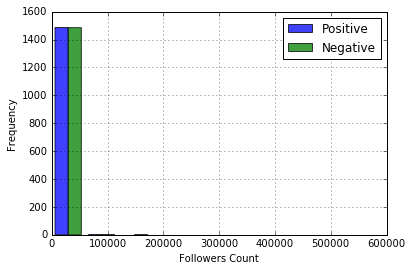

In [10]:
sample_number = 1500
df_fwcnt = df_full[pd.notnull(df_full['followers_count'])]
users_wth_neg_class = df_fwcnt[df_fwcnt["cls"]==0].sample(sample_number)
users_wth_pos_class = df_fwcnt[df_fwcnt["cls"]==1].sample(sample_number)

def print_stats(prefix, ds):  
    print '\r[{}] min: {:d}\tmax: {:d}\tmean: {:1.2f}\tmedian: {:d}'.format(
        prefix,int(ds.min()),int(ds.max()),ds.mean(),int(ds.median()))

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    #Calculate min max and median. Plot histogram
    pos_flwcnt = users_wth_pos_class['followers_count']
    neg_flwcnt = users_wth_neg_class['followers_count']
    
    print_stats('Positive', pos_flwcnt)
    print_stats('Negative', neg_flwcnt)
   
    plt.hist([pos_flwcnt, neg_flwcnt],  alpha=0.75, label=['Positive','Negative'])
    axes = pl.gca()
    axes.set_xlabel('Followers Count')
    axes.set_ylabel('Frequency')
    #axes.set_yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

Медиана много меньше среднего: несколько очень популярных пользователей "перетягивают" на себя среднее, в то время как основная масса имеет куда меньше подписчиков, о чем и свидетельствует значение медианы.

Медианы Positive и Negative примерно совпадают, в то время как среднее у Negative больше примерно на 20%. Это означает, что:
* Основная часть обоих классов не отличается по популярности
* Среди Negative больше самых популярных (в обучающей выборке).


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [11]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1055.0,1962.0,9482.0,21338.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1197.0,837.0,19299.0,7184.0,110.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,577.0,7852.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,None,None,None,2013-06,2376.0,2436.0,187955.0,88156.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,None,None,None,2015-12,1246.0,970.0,36970.0,27066.0,75.0
